## Оценка риска ДТП по выбранному маршруту движения

In [48]:
# Импорт бибилиотек
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import catboost as cb

from catboost import CatBoostRegressor
from catboost import CatBoostClassifier
from catboost import MetricVisualizer
from catboost import  Pool

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sqlalchemy import create_engine 

## Подключение к базе. Загрузка таблицы sql

In [49]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 
 
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [50]:
engine = create_engine(connection_string) 

## Проведение первичного исследования таблиц

In [51]:
query = '''
SELECT *
FROM collisions;
'''

df_collisions = pd.read_sql_query(query, con=engine) 

In [52]:
display(df_collisions.head(3))
display(df_collisions.info())

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0.0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1.0,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 20 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   case_id                      1400000 non-null  object 
 1   county_city_location         1400000 non-null  object 
 2   county_location              1400000 non-null  object 
 3   distance                     1400000 non-null  float64
 4   direction                    1059358 non-null  object 
 5   intersection                 1387781 non-null  float64
 6   weather_1                    1392741 non-null  object 
 7   location_type                518779 non-null   object 
 8   collision_damage             1400000 non-null  object 
 9   party_count                  1400000 non-null  int64  
 10  primary_collision_factor     1391834 non-null  object 
 11  pcf_violation_category       1372046 non-null  object 
 12  type_of_collision            1388176 non-n

None

In [53]:
query = '''
SELECT *
FROM parties
'''

df_parties = pd.read_sql_query(query, con=engine) 

In [54]:
display(df_parties.head(3))
display(df_parties.info())

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2752408 entries, 0 to 2752407
Data columns (total 9 columns):
 #   Column               Dtype  
---  ------               -----  
 0   id                   int64  
 1   case_id              object 
 2   party_number         int64  
 3   party_type           object 
 4   at_fault             int64  
 5   insurance_premium    float64
 6   party_sobriety       object 
 7   party_drug_physical  object 
 8   cellphone_in_use     float64
dtypes: float64(2), int64(3), object(4)
memory usage: 189.0+ MB


None

In [55]:
query = '''
SELECT *
FROM vehicles  
'''

df_vehicless = pd.read_sql_query(query, con=engine) 

In [56]:
display(df_vehicless.head(3))
display(df_vehicless.info())

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3.0
1,1,3858022,1,sedan,auto,3.0
2,1175712,5305030,1,sedan,auto,3.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021234 entries, 0 to 1021233
Data columns (total 6 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1021234 non-null  int64  
 1   case_id               1021234 non-null  object 
 2   party_number          1021234 non-null  int64  
 3   vehicle_type          1021234 non-null  object 
 4   vehicle_transmission  997575 non-null   object 
 5   vehicle_age           996652 non-null   float64
dtypes: float64(1), int64(2), object(3)
memory usage: 46.7+ MB


None

Краткое описание таблиц:
- collisions — общая информация о ДТП. Имеет уникальный case_id. Эта таблица описывает общую информацию о ДТП. Например, где оно произошло и когда;
- parties — информация об участниках ДТП. Имеет неуникальный case_id, который сопоставляется с соответствующим ДТП в таблице collisions. Каждая строка здесь описывает одну из сторон, участвующих в ДТП. Если столкнулись две машины, в этой таблице должно быть две строки с совпадением case_id. Если нужен уникальный идентификатор, это case_id and party_number;
- vehicles — информация о пострадавших машинах. Имеет неуникальные case_id и неуникальные party_number, которые сопоставляются с таблицей collisions и таблицей parties. Если нужен уникальный идентификатор, это case_id and party_number.

У всех таблиц есть общий ключ для связи.

##  Проведие статистического анализ факторов ДТП

### Количество аварий по месяцам

In [57]:
query = '''
SELECT EXTRACT(YEAR FROM collision_date) AS year_collision,
       EXTRACT(MONTH FROM collision_date) AS month_collision,
       COUNT(case_id) AS count_collision
FROM collisions
GROUP BY 1, 2
ORDER BY 1, 3 DESC
'''
collisions_count = pd.read_sql_query(query, con=engine) 

In [60]:
collisions_count.head(3)

,year_collision,month_collision,count_collision
0,2009.0,10.0,37835
1,2009.0,5.0,36916
2,2009.0,3.0,36648


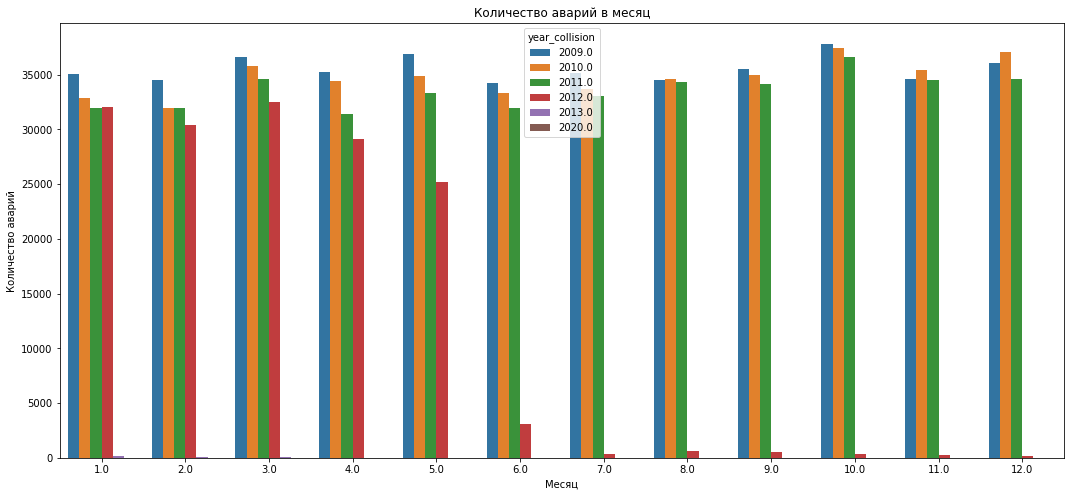

In [61]:
fig, ax = plt.subplots(figsize=(18, 8))
sns.barplot(data = collisions_count, x='month_collision', y='count_collision', hue='year_collision')
plt.title('Количество аварий в месяц')
plt.xlabel('Месяц')
plt.ylabel('Количество аварий')
plt.show()

Наибольшее количество ДТП за 2009-20011 приходится на октябрь, декабрь и март месяц. В 2012 году с июня месяца обнаружено снижение количества ДТП с 25000-33000 до 200-3000. Возникает вопрос о причинах отсутсвия данных, так как вряд ли так может снизиться аварийность.

### Аналитические задачи:
- провести анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП (связать collisions и parties);
- проанадизировать самые частые причины ДТП (таблица parties);
- изучить трезвость участников ДТП и оценить его влияние на виновность участника;
- изучить серьезность повреждений ТС в зависимости от трезвости участника;
- провести анализ зависимости ДТП и погоды;
- Выявить типы КПП и возраст автомобилей, и ценить их влияние на ДТП.

### Анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП

In [62]:
query = '''
SELECT collision_damage,
       road_surface AS road_surface,
       COUNT(collision_damage)  
FROM collisions
GROUP BY 1, 2
ORDER BY 1, 3 DESC
'''
road_surface = pd.read_sql_query(query, con=engine)
road_surface.head()

,collision_damage,road_surface,count
0,fatal,dry,9823
1,fatal,wet,857
2,fatal,None,55
3,fatal,snowy,46
4,fatal,slippery,12


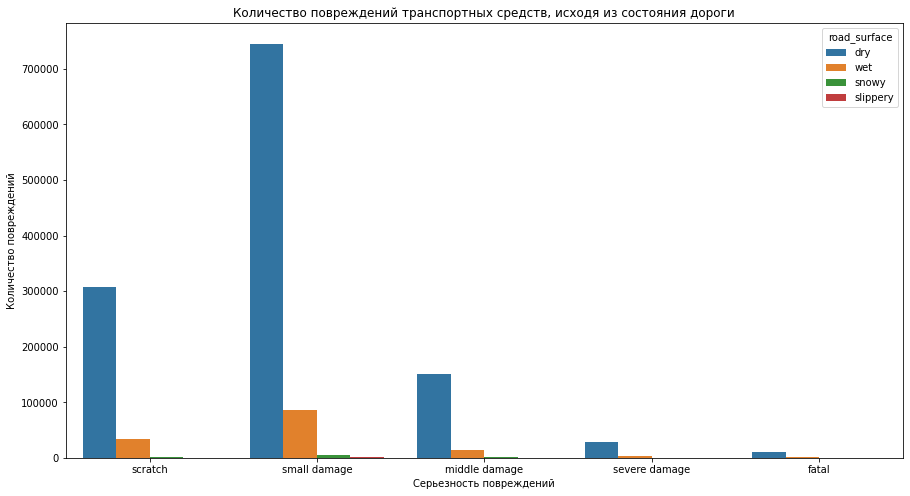

In [64]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(
    x='collision_damage', 
    y='count', 
    hue='road_surface', 
    ci=None,
    order=['scratch', 'small damage', 'middle damage', 'severe damage', 'fatal'],
    data=road_surface
)
plt.title('Количество повреждений транспортных средств, исходя из состояния дороги')
plt.xlabel('Серьезность повреждений')
plt.ylabel('Количество повреждений')
plt.show()

Наибольшее количество ДТП происходит на сухой дороге. Также много ДТП происходит на сырой дороге. Больше всего повреждений - это небольшие повреждения и царапины, как на сухой дороге, так и на мокрой.

In [65]:
query = '''
SELECT collision_damage,
       road_condition_1 AS road_condition,
       COUNT(collision_damage)  
FROM collisions
WHERE road_condition_1 != 'normal'
GROUP BY 1, 2
ORDER BY 1, 3 DESC
'''
road_collisions = pd.read_sql_query(query, con=engine)
road_collisions.head()

,collision_damage,road_condition,count
0,fatal,construction,174
1,fatal,other,54
2,fatal,obstruction,49
3,fatal,loose material,34
4,fatal,holes,23


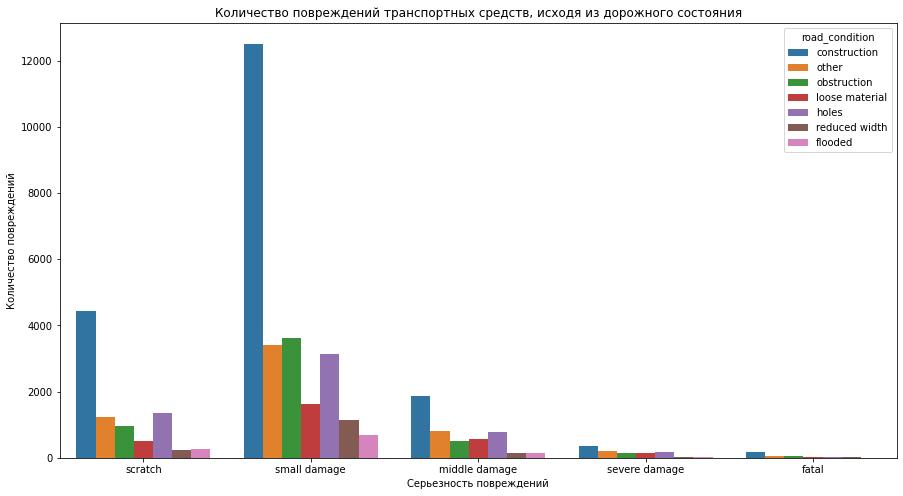

In [66]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(
    x='collision_damage', 
    y='count', 
    hue="road_condition", 
    ci=None,
    order=['scratch', 'small damage', 'middle damage', 'severe damage', 'fatal'],
    data=road_collisions
)
plt.title('Количество повреждений транспортных средств, исходя из дорожного состояния')
plt.xlabel('Серьезность повреждений')
plt.ylabel('Количество повреждений')
plt.show()

Ненадлежащее состояние дорог является частой причиной ДТП. Так, строительство, препятствие на дороге и отверстия приводят к ДТП, которые повлекли такие повреждения, как царапины, небольшие и средние вореждения машин.

In [67]:
query = '''
SELECT collision_damage,
       COUNT(collision_damage)  
FROM collisions
WHERE road_condition_1 = 'normal'
GROUP BY 1
ORDER BY 2 DESC
'''
road_collisions_nornal = pd.read_sql_query(query, con=engine)
road_collisions_nornal.head()

,collision_damage,count
0,small damage,812420
1,scratch,333996
2,middle damage,160428
3,severe damage,29439
4,fatal,10372


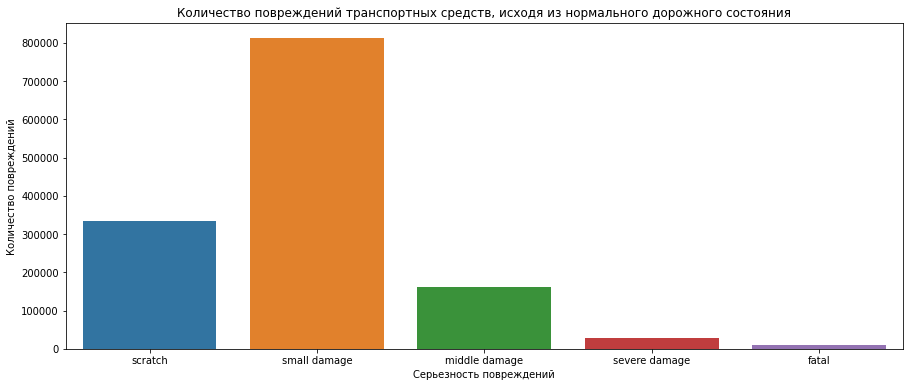

In [68]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(
    x='collision_damage', 
    y='count', 
    ci=None,
    order=['scratch', 'small damage', 'middle damage', 'severe damage', 'fatal'],
    data=road_collisions_nornal
)
plt.title('Количество повреждений транспортных средств, исходя из нормального дорожного состояния')
plt.xlabel('Серьезность повреждений')
plt.ylabel('Количество повреждений')
plt.show()

При нормальном сотоянии дорожного покрытия чаще всего происходят ДТП небольшой тяжести, а без повреждения ТС (царапины).

### Самые частые причины ДТП

In [69]:
query = '''
SELECT primary_collision_factor,
       COUNT(primary_collision_factor) count_collision_factor
FROM collisions
WHERE primary_collision_factor != 'unknown' 
GROUP BY 1
ORDER BY 2 DESC
'''
collisions_reasons = pd.read_sql_query(query, con=engine)
collisions_reasons

,primary_collision_factor,count_collision_factor
0,vehicle code violation,1316453
1,other than driver,29780
2,other improper driving,8470
3,fell asleep,117


In [70]:
query = '''
SELECT PCF_VIOLATION_CATEGORY,
       COUNT(PCF_VIOLATION_CATEGORY) AS count_collision_factor
FROM collisions
GROUP BY 1
ORDER BY 2 DESC
'''
collisions_category = pd.read_sql_query(query, con=engine)
collisions_category

,pcf_violation_category,count_collision_factor
0,speeding,438439
1,improper turning,238987
2,automobile right of way,158291
3,dui,110476
4,unsafe lane change,93962
5,traffic signals and signs,72751
6,unsafe starting or backing,55674
7,unknown,39558
8,wrong side of road,33631
9,following too closely,30033


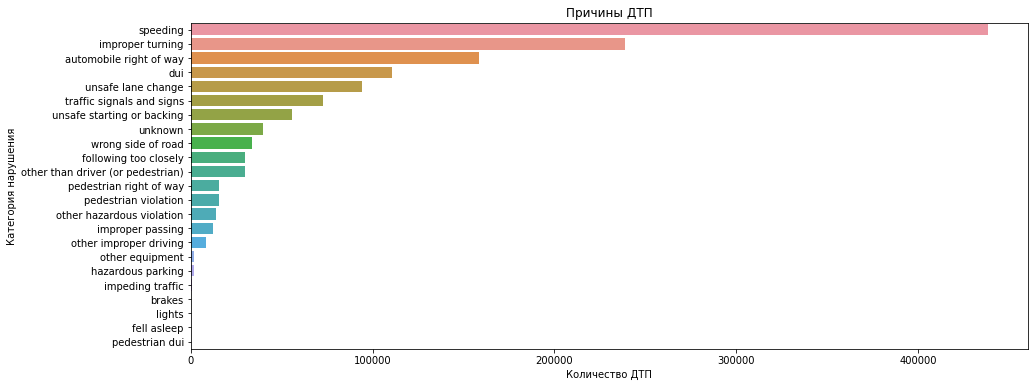

In [71]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(
    x='count_collision_factor', 
    y='pcf_violation_category', 
    ci=None,
    data=collisions_category
)
plt.title('Причины ДТП')
plt.xlabel('Количество ДТП')
plt.ylabel('Категория нарушения')
plt.show()

Основные причины ДТП - нарушение скоростного режима (438 тыс.), поворот в неустановленном месте (238 тыс.), непредоставление преимущества (158 тыс.) и управление в состоянии опьянения (110 тыс.).

## Создание модели для оценки водительского риска

Для создания модели нам понадобятся следующие признаки:
- **таблица collisions**: 
 - intersection (является ли место происшествия перекрестком)
 - weather_1 (погода)
 - road_surface (состояние дороги)
 - lighting (освещение)
 - location_type (тип дороги)
 - road_condition_1 (состояние дорожного покрытия)
- **таблица parties**:
  - at_fault (виновность участника) - целевой признак
  - party_sobriety (трезвость участника
  - party_drug_physical (состояние участника: физическое или с учётом принятых лекарств)
  - cellphone_in_use (наличие телефона в автомобиле - возможности разговаривать по громкой связи)
- **таблица vehicles**:
  - vehicle_type (тип кузова)
  - vehicle_transmission (тип КПП)
  - vehicle_age (возраст автомобиля)

Все эти признаки важны, так как отражают и объективные причины ДТП (состояние дороги и транспортного средства), и субъективные - состояние участника ДТП.

### Подготовка данных

In [72]:
query = '''
with 
c AS (SELECT case_id,
             intersection,
             weather_1,
             road_surface,
             lighting,
             location_type,
             road_condition_1
      FROM collisions
      WHERE EXTRACT(YEAR FROM collision_date) = 2012
            AND collision_damage != 'scratch'),
p AS (SELECT case_id,
             at_fault,
             party_sobriety,
             party_drug_physical,
             cellphone_in_use
      FROM parties
      WHERE party_type = 'car'),
      
v AS (SELECT case_id,
             vehicle_type,
             vehicle_transmission,
             vehicle_age
       FROM vehicles),
       
c_i as (SELECT case_id
        FROM case_ids)
        
SELECT  p.at_fault,
        p.party_sobriety,
        p.party_drug_physical,
        p.cellphone_in_use,
        c.intersection,
        c.weather_1,
        c.road_surface,
        c.lighting,
        c.location_type,
        c.road_condition_1,
        v.vehicle_type,
        v.vehicle_transmission,
        v.vehicle_age
FROM c_i
JOIN c on c_i.case_id = c.case_id
JOIN p on c_i.case_id = p.case_id
JOIN v on c_i.case_id = v.case_id
'''
df = pd.read_sql_query(query, con=engine)

In [73]:
# Получение общей информации о датафрейме
display(df.head(5))
display(df.info())

,at_fault,party_sobriety,party_drug_physical,cellphone_in_use,intersection,weather_1,road_surface,lighting,location_type,road_condition_1,vehicle_type,vehicle_transmission,vehicle_age
0,1,had not been drinking,None,0.0,1.0,cloudy,dry,daylight,None,other,sedan,auto,2.0
1,0,had not been drinking,None,0.0,1.0,cloudy,dry,daylight,None,other,sedan,auto,2.0
2,1,had not been drinking,None,0.0,1.0,clear,dry,daylight,None,normal,sedan,auto,5.0
3,0,had not been drinking,None,0.0,1.0,clear,dry,daylight,None,normal,sedan,auto,5.0
4,0,had not been drinking,None,0.0,1.0,clear,dry,daylight,None,normal,sedan,auto,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118411 entries, 0 to 118410
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   at_fault              118411 non-null  int64  
 1   party_sobriety        116682 non-null  object 
 2   party_drug_physical   8695 non-null    object 
 3   cellphone_in_use      107507 non-null  float64
 4   intersection          118043 non-null  float64
 5   weather_1             118022 non-null  object 
 6   road_surface          117645 non-null  object 
 7   lighting              118080 non-null  object 
 8   location_type         55137 non-null   object 
 9   road_condition_1      117843 non-null  object 
 10  vehicle_type          118411 non-null  object 
 11  vehicle_transmission  116545 non-null  object 
 12  vehicle_age           115046 non-null  float64
dtypes: float64(3), int64(1), object(9)
memory usage: 11.7+ MB


None

In [74]:
# Проверка на наличие пропусков
df.isna().sum()

at_fault                     0
party_sobriety            1729
party_drug_physical     109716
cellphone_in_use         10904
intersection               368
weather_1                  389
road_surface               766
lighting                   331
location_type            63274
road_condition_1           568
vehicle_type                 0
vehicle_transmission      1866
vehicle_age               3365
dtype: int64

In [75]:
df.isna().mean()

at_fault                0.000000
party_sobriety          0.014602
party_drug_physical     0.926569
cellphone_in_use        0.092086
intersection            0.003108
weather_1               0.003285
road_surface            0.006469
lighting                0.002795
location_type           0.534359
road_condition_1        0.004797
vehicle_type            0.000000
vehicle_transmission    0.015759
vehicle_age             0.028418
dtype: float64

Столбец party_drug_physical мог бы быть полезен, но в нем отсутствует более 90% данных, поэтому особой ценности он не представляет, удалим его.

In [76]:
df = df.drop('party_drug_physical', axis=1)

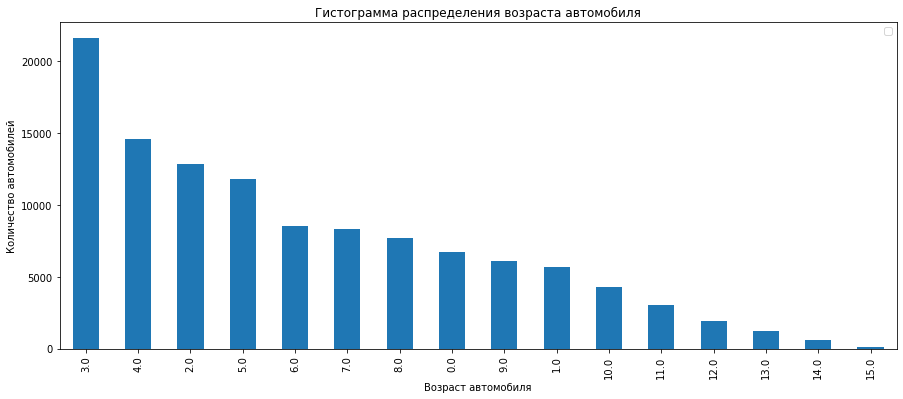

In [334]:
# Проверим распределение возраста автомобилей
df['vehicle_age'].value_counts().plot(figsize=(15,6), kind='bar')
plt.title('Гистограмма распределения возраста автомобиля')
plt.xlabel('Возраст автомобиля')
plt.ylabel('Количество автомобилей')
plt.legend([])
plt.show()

In [335]:
# Заменим значения возраста автомобиля > 15 на 15
df.loc[df['vehicle_age'] > 10, 'vehicle_age'] = 10

In [77]:
df.describe()

,at_fault,cellphone_in_use,intersection,vehicle_age
count,118411.000000,107507.000000,118043.000000,115046.000000
mean,0.469686,0.021320,0.234711,4.908263
std,0.499082,0.144448,0.423820,3.266265
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,3.000000
50%,0.000000,0.000000,0.000000,4.000000
75%,1.000000,0.000000,0.000000,7.000000
max,1.000000,1.000000,1.000000,161.000000


In [78]:
# Заменим пропуски в числовых данных на значение медианы
df = df.fillna(df[{'vehicle_age','cellphone_in_use','intersection'}].median())

In [79]:
df.isna().sum()

at_fault                    0
party_sobriety           1729
cellphone_in_use            0
intersection                0
weather_1                 389
road_surface              766
lighting                  331
location_type           63274
road_condition_1          568
vehicle_type                0
vehicle_transmission     1866
vehicle_age                 0
dtype: int64

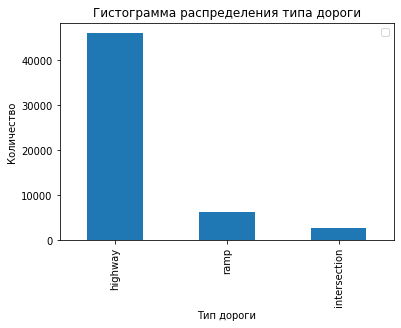

In [80]:
# Посмотрим на распределение значений столбца location_type
df['location_type'].value_counts().plot(figsize=(6,4), kind='bar')
plt.title('Гистограмма распределения типа дороги')
plt.xlabel('Тип дороги')
plt.ylabel('Количество')
plt.legend([])
plt.show()

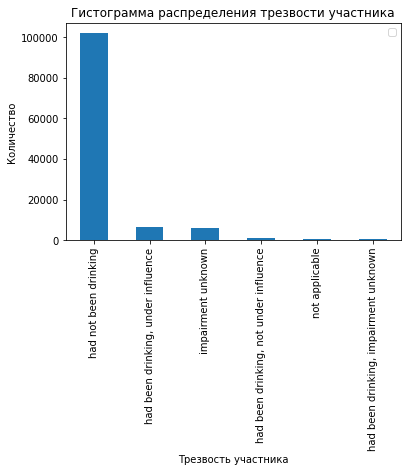

In [81]:
# Посмотрим на распределение значений столбца location_type
df['party_sobriety'].value_counts().plot(figsize=(6,4), kind='bar')
plt.title('Гистограмма распределения трезвости участника')
plt.xlabel('Трезвость участника')
plt.ylabel('Количество')
plt.legend([])
plt.show()

Заменим пропуски в столбце 'party_sobriety', 'weather_1', 'road_surface', 'lighting', 'road_condition_1', 'vehicle_transmission' значениями с такой же вероятностью.

In [82]:
for i in df[['location_type', 'party_sobriety', 'weather_1', 'road_surface', 'lighting', 'road_condition_1', 'vehicle_transmission']]:
    mask = df[i].isna()
    p = df[i].value_counts() / len(df[i].dropna())
    df.loc[mask, i] = np.random.choice(p.index.to_list(), size=mask.sum(), p=p.to_list())

In [83]:
df.isna().sum()

at_fault                0
party_sobriety          0
cellphone_in_use        0
intersection            0
weather_1               0
road_surface            0
lighting                0
location_type           0
road_condition_1        0
vehicle_type            0
vehicle_transmission    0
vehicle_age             0
dtype: int64

Подготовили данные:
- удалили столбец party_drug_physical, так как пропусков более 90%, для модели не даст никакой значимости;
- в числовых признаках 'vehicle_age','cellphone_in_use','intersection' заменили пропуски медианой;
- пропуски в признаках 'party_sobriety', 'weather_1', 'road_surface', 'lighting', 'road_condition_1', 'vehicle_transmission' заменили теми же значениями с такой же вероятностью.

In [84]:
df.head(3)

,at_fault,party_sobriety,cellphone_in_use,intersection,weather_1,road_surface,lighting,location_type,road_condition_1,vehicle_type,vehicle_transmission,vehicle_age
0,1,had not been drinking,0.0,1.0,cloudy,dry,daylight,ramp,other,sedan,auto,2.0
1,0,had not been drinking,0.0,1.0,cloudy,dry,daylight,highway,other,sedan,auto,2.0
2,1,had not been drinking,0.0,1.0,clear,dry,daylight,highway,normal,sedan,auto,5.0


In [85]:
# Создадим фрейм для кодирования и масштабирования
df_encoder = df.copy()

In [86]:
# Создадим признаки и целевой признак
features = df.drop('at_fault', axis=1)
target = df['at_fault']

features_encoder = df_encoder.drop('at_fault', axis=1)
target_encoder = df_encoder['at_fault']

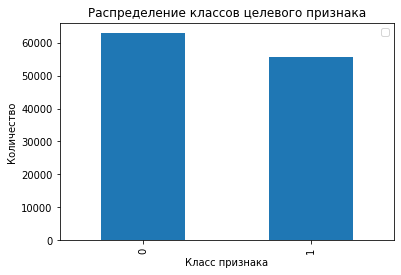

In [87]:
# Посмотрим на распределение целевого призака
target.value_counts().plot(figsize=(6,4), kind='bar')
plt.title('Распределение классов целевого признака')
plt.xlabel('Класс признака')
plt.ylabel('Количество')
plt.legend([])
plt.show()

В целом можно утверждать о балансе классов.

In [88]:
# Разделим на обучающую, валидационную и тестовую выборки для СatBoost
features_train, features_other, target_train, target_other = train_test_split(features.copy(), target.copy(), test_size=0.4, 
                                                                              shuffle=True, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_other.copy(), target_other.copy(), test_size=0.5, 
                                                                            shuffle=True, random_state=12345)
# Проверим соотношение выборок
display(features_train.shape, features_valid.shape, features_test.shape)
display(target_train.shape, target_valid.shape, target_test.shape)

(71046, 11)

(23682, 11)

(23683, 11)

(71046,)

(23682,)

(23683,)

In [89]:
# Разделим на обучающую, валидационную и тестовую выборки для моделей DecisionTree и RandomForest
features_train_encoder, features_other_encoder, target_train_encoder, target_other_encoder = train_test_split(
    features_encoder.copy(), target_encoder.copy(), test_size=0.4, shuffle=True, random_state=12345)

features_valid_encoder, features_test_encoder, target_valid_encoder, target_test_encoder = train_test_split(
    features_other_encoder.copy(), target_other_encoder.copy(), test_size=0.5, shuffle=True, random_state=12345)


# Проверим соотношение выборок
display(features_train_encoder.shape, features_valid_encoder.shape, features_test_encoder.shape)
display(target_train_encoder.shape, target_valid_encoder.shape, target_test_encoder.shape)

(71046, 11)

(23682, 11)

(23683, 11)

(71046,)

(23682,)

(23683,)

In [90]:
# Масштабируем числовые признаки
numeric = ['vehicle_age']

scaler = StandardScaler()
scaler.fit(features_train_encoder[numeric])

features_train_encoder[numeric] = scaler.transform(features_train_encoder[numeric])
features_valid_encoder[numeric] = scaler.transform(features_valid_encoder[numeric])
features_test_encoder[numeric] = scaler.transform(features_test_encoder[numeric])

In [91]:
# Закодируем категориальные признаки
categorial = ['party_sobriety', 'weather_1', 'road_surface', 'lighting', 'location_type', 'road_condition_1', 
              'vehicle_type', 'vehicle_transmission']

encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoder.fit(features_train_encoder[categorial])

features_train_encoder_ohe = pd.DataFrame(encoder.transform(features_train_encoder[categorial]), columns = encoder.get_feature_names(categorial))
features_valid_encoder_ohe = pd.DataFrame(encoder.transform(features_valid_encoder[categorial]), columns = encoder.get_feature_names(categorial))
features_test_encoder_ohe = pd.DataFrame(encoder.transform(features_test_encoder[categorial]), columns = encoder.get_feature_names(categorial))

In [92]:
# Удаляем столбцы с категориальными признаками
features_train_encoder = features_train_encoder.drop(categorial, axis=1)
features_valid_encoder = features_valid_encoder.drop(categorial, axis=1)
features_test_encoder = features_test_encoder.drop(categorial, axis=1)

In [93]:
# объединяем таблицы
features_train_encoder = pd.concat([features_train_encoder_ohe.reset_index(drop=True), features_train_encoder.reset_index(drop=True)], axis=1, ignore_index=False)
features_valid_encoder = pd.concat([features_valid_encoder_ohe.reset_index(drop=True), features_valid_encoder.reset_index(drop=True)], axis=1, ignore_index=False)
features_test_encoder = pd.concat([features_test_encoder_ohe.reset_index(drop=True), features_test_encoder.reset_index(drop=True)], axis=1, ignore_index=False)

In [94]:
# Проверим кодирование и масштабирование признаков
features_train_encoder.head(3)

,"party_sobriety_had been drinking, impairment unknown","party_sobriety_had been drinking, not under influence","party_sobriety_had been drinking, under influence",party_sobriety_had not been drinking,party_sobriety_impairment unknown,party_sobriety_not applicable,weather_1_clear,weather_1_cloudy,weather_1_fog,weather_1_other,...,vehicle_type_coupe,vehicle_type_hatchback,vehicle_type_minivan,vehicle_type_other,vehicle_type_sedan,vehicle_transmission_auto,vehicle_transmission_manual,cellphone_in_use,intersection,vehicle_age
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.186693
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-1.191695
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.577443


### DecisionTreeClassifier

In [95]:
# Зададим параметры модели
decision_tree_params = {
    'max_depth': range(1, 20, 2),
    'min_samples_split': [5], 
    'min_samples_leaf': [25],
    'class_weight':['balanced']
}

dt_gs = GridSearchCV(DecisionTreeClassifier(random_state=5),
                         decision_tree_params, n_jobs=-1, cv=5, scoring='roc_auc')
dt_f1 = dt_gs.fit(features_train_encoder, target_train_encoder)

In [96]:
# Найдем лучшие гиперпараметры
dt_f1.best_params_

{'class_weight': 'balanced',
 'max_depth': 9,
 'min_samples_leaf': 25,
 'min_samples_split': 5}

In [97]:
%%time 
# Предсказания модели с лучшими гиперпараметрами
pred_dt = dt_f1.best_estimator_.predict(features_valid_encoder)

CPU times: user 12 ms, sys: 7.99 ms, total: 19.9 ms
Wall time: 19.8 ms


In [98]:
print('F1 на валидационной выборке:', f1_score(pred_dt, target_valid_encoder))
print('ROC_AUC на валидационной выборке:', roc_auc_score(pred_dt, target_valid_encoder))

F1 на валидационной выборке: 0.42296338169712955
ROC_AUC на валидационной выборке: 0.6435224415252992


### RandomForestClassifier

In [99]:
# Зададим гиперпараметры модели
param_grid = {
    'n_estimators': range(80, 101, 5),
    'max_depth': range(1, 11, 2),
    'class_weight':['balanced']
}

rf = RandomForestClassifier(random_state=5)
rf_grid = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1, verbose=2)

In [100]:
%%time
# Обучим модель
rf_grid.fit(features_train_encoder, target_train_encoder)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
CPU times: user 2.38 s, sys: 137 ms, total: 2.52 s
Wall time: 1min 5s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=5), n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'max_depth': range(1, 11, 2),
                         'n_estimators': range(80, 101, 5)},
             verbose=2)

In [101]:
# Найдем лучшие гиперпараметры
rf_grid.best_params_

{'class_weight': 'balanced', 'max_depth': 9, 'n_estimators': 90}

In [102]:
%%time 
# Предсказания модели с лучшими гиперпараметрами
pred_rf = rf_grid.best_estimator_.predict(features_valid_encoder)

CPU times: user 157 ms, sys: 4.79 ms, total: 162 ms
Wall time: 166 ms


In [103]:
print('F1 на валидационной выборке:', f1_score(pred_rf, target_valid_encoder))
print('ROC_AUC на валидационной выборке:', roc_auc_score(pred_rf, target_valid_encoder))

F1 на валидационной выборке: 0.40534578954197475
ROC_AUC на валидационной выборке: 0.6553482611662811


### CatBoostClassifier

In [104]:
model_cat = cb.CatBoostClassifier(loss_function='Logloss', eval_metric='AUC')

In [105]:
# Зададим категориальные признаки
cat_features = ['party_sobriety', 'weather_1', 'road_surface', 'lighting', 'location_type', 'road_condition_1', 
              'vehicle_type', 'vehicle_transmission']

In [106]:
# Зададим гиперпараметры модели
grid = {'iterations': [100, 120],
        'learning_rate': [0.001, 0.002],
        'depth': range(6, 9)
       }

In [107]:
%%time
catboost_grid = model_cat.grid_search(grid, Pool(features_train, target_train, cat_features=cat_features), cv=3, 
                                  verbose=50)

0:	test: 0.5881524	best: 0.5881524 (0)	total: 88.6ms	remaining: 8.78s
1:	test: 0.5881524	best: 0.5881524 (0)	total: 111ms	remaining: 5.46s
2:	test: 0.5960176	best: 0.5960176 (2)	total: 130ms	remaining: 4.19s
3:	test: 0.5960176	best: 0.5960176 (2)	total: 149ms	remaining: 3.58s
4:	test: 0.5960176	best: 0.5960176 (2)	total: 166ms	remaining: 3.15s
5:	test: 0.5967603	best: 0.5967603 (5)	total: 185ms	remaining: 2.89s
6:	test: 0.5992192	best: 0.5992192 (6)	total: 204ms	remaining: 2.71s
7:	test: 0.5985119	best: 0.5992192 (6)	total: 223ms	remaining: 2.56s
8:	test: 0.5993843	best: 0.5993843 (8)	total: 242ms	remaining: 2.44s
9:	test: 0.5985216	best: 0.5993843 (8)	total: 260ms	remaining: 2.34s
10:	test: 0.5986372	best: 0.5993843 (8)	total: 279ms	remaining: 2.25s
11:	test: 0.5991389	best: 0.5993843 (8)	total: 313ms	remaining: 2.29s
12:	test: 0.5991442	best: 0.5993843 (8)	total: 338ms	remaining: 2.26s
13:	test: 0.6012270	best: 0.6012270 (13)	total: 362ms	remaining: 2.22s
14:	test: 0.6015015	best: 0.

In [108]:
# Найдем лучшие гиперпараметры
catboost_grid['params']

{'depth': 6, 'iterations': 100, 'learning_rate': 0.002}

In [109]:
%%time
# Зададим гиперпараметры модели
final_cat = cb.CatBoostClassifier(**catboost_grid['params'],
                              eval_metric='AUC', verbose=100, train_dir='learning_rate_0.01')

CPU times: user 57 µs, sys: 1 µs, total: 58 µs
Wall time: 61 µs


In [110]:
# Обучим модель
final_cat.fit(Pool(features_train, target_train, cat_features=cat_features)) 

0:	total: 21.8ms	remaining: 2.16s
99:	total: 1.94s	remaining: 0us


In [111]:
%%time
# Предсказания модели
pred_cat = final_cat.predict(features_valid)
print('F1 на валидационной выборке:', f1_score(pred_cat, target_valid))
print('ROC_AUC на валидационной выборке:', roc_auc_score(pred_cat, target_valid))

F1 на валидационной выборке: 0.3414914232397904
ROC_AUC на валидационной выборке: 0.7091227135588284
CPU times: user 96.6 ms, sys: 8.86 ms, total: 105 ms
Wall time: 119 ms


In [112]:
# Посмотрим на график обучения модели
MetricVisualizer(['learning_rate_0.02']).start()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

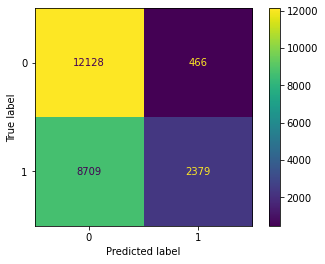

In [113]:
# Построим матрицу ошибок для модели CatBoost
matrix = confusion_matrix(target_valid, pred_cat)
cm_display = ConfusionMatrixDisplay(matrix).plot()

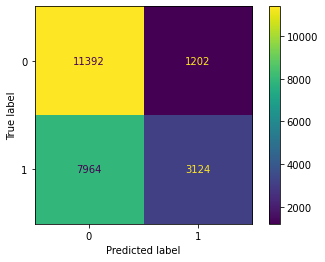

[CV] END class_weight=balanced, max_depth=1, n_estimators=80; total time=   1.1s
[CV] END class_weight=balanced, max_depth=1, n_estimators=85; total time=   1.0s
[CV] END class_weight=balanced, max_depth=1, n_estimators=85; total time=   1.0s
[CV] END class_weight=balanced, max_depth=1, n_estimators=90; total time=   1.0s
[CV] END class_weight=balanced, max_depth=1, n_estimators=95; total time=   1.1s
[CV] END class_weight=balanced, max_depth=1, n_estimators=100; total time=   1.1s
[CV] END class_weight=balanced, max_depth=3, n_estimators=80; total time=   1.3s
[CV] END class_weight=balanced, max_depth=3, n_estimators=80; total time=   1.4s
[CV] END class_weight=balanced, max_depth=3, n_estimators=85; total time=   1.4s
[CV] END class_weight=balanced, max_depth=3, n_estimators=90; total time=   1.5s
[CV] END class_weight=balanced, max_depth=3, n_estimators=95; total time=   1.5s
[CV] END class_weight=balanced, max_depth=3, n_estimators=100; total time=   1.6s
[CV] END class_weight=bala

In [114]:
# Построим матрицу ошибок для модели Randomforest
matrix_rf = confusion_matrix(target_valid_encoder, pred_rf)
cm_display_rf = ConfusionMatrixDisplay(matrix_rf).plot()

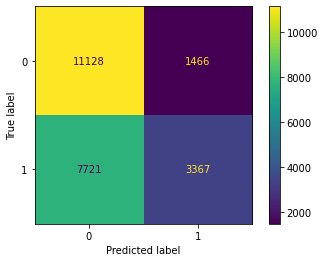

In [115]:
# Построим матрицу ошибок для модели Randomforest
matrix_dt = confusion_matrix(target_valid_encoder, pred_dt)
cm_display_dt = ConfusionMatrixDisplay(matrix_dt).plot()

In [116]:
data = {'F1': [0.422, 0.405, 0.341], 
        'AUC_ROC': [0.643, 0.655, 0.709]}

table = pd.DataFrame(data, index=['DecisionTree', 'RandomForest', 'CatBoost'])
table.sort_values('AUC_ROC', ascending=False)

,F1,AUC_ROC
CatBoost,0.341,0.709
RandomForest,0.405,0.655
DecisionTree,0.422,0.643


Наилучшей моделью оказалась модель CatBoost, которая показала значение ROC-AUC 0.709, количество FN - 8709, FP - 466, при этом модель RandomForest показала количество ложноположительных ответов меньше - 7964, FP - 1202.

### Тестирование модели CatBoost

In [117]:
# объединим обучающую и валидационные выбоки
features_train_valid = pd.concat([features_train, features_valid])
target_train_valid = pd.concat([target_train, target_valid])

In [118]:
%%time
# Обучим модель
final_cat.fit(Pool(features_train_valid, target_train_valid, cat_features=cat_features)) 

0:	total: 19.3ms	remaining: 1.92s
99:	total: 1.67s	remaining: 0us
CPU times: user 5.83 s, sys: 67.4 ms, total: 5.9 s
Wall time: 1.96 s


In [119]:
%%time
# Предсказания модели
pred_cat_test = final_cat.predict(features_test)

CPU times: user 72.1 ms, sys: 4.91 ms, total: 77 ms
Wall time: 68 ms


In [120]:
print('F1 на валидационной выборке:', f1_score(pred_cat_test, target_test))
print('ROC_AUC на валидационной выборке:', roc_auc_score(pred_cat_test, target_test))

F1 на валидационной выборке: 0.3469024025094461
ROC_AUC на валидационной выборке: 0.7090199113540029


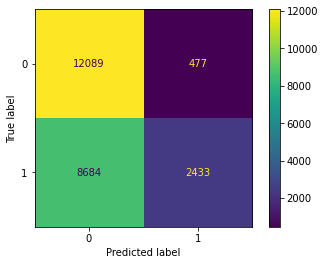

In [121]:
matrix = confusion_matrix(target_test, pred_cat_test)
cm_display = ConfusionMatrixDisplay(matrix).plot()

Модель CatBoost на тестовой выборке показала почти такие же результаты, как и на валидационной. ROC-AUC 0.709, количество FN ответов 8684, FP - 477.

## Проведите анализ важности факторов ДТП

In [122]:
importances = final_cat.feature_importances_

In [123]:
feature_list = list(features_train_valid.columns)

In [124]:
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})

In [125]:
feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)

In [126]:
feature_results.head()

,feature,importance
0,party_sobriety,98.402430
1,vehicle_age,0.595397
2,vehicle_transmission,0.578342
3,intersection,0.372853
4,cellphone_in_use,0.050978


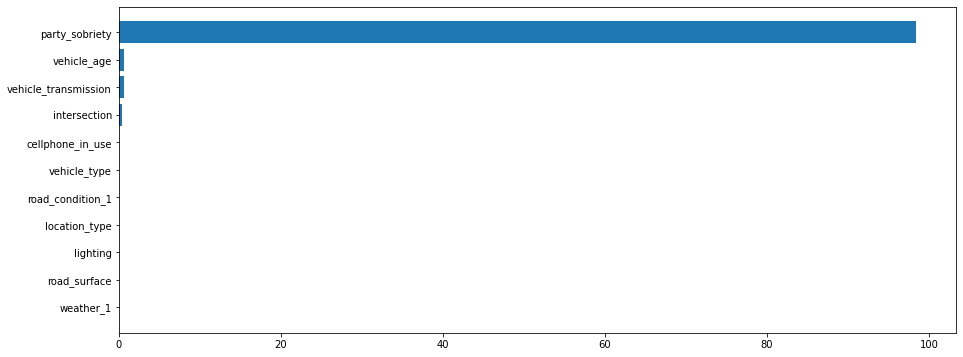

In [127]:
indices = np.argsort(importances)

fig, ax = plt.subplots(figsize=(15, 6))
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(features_train_valid.columns)[indices])

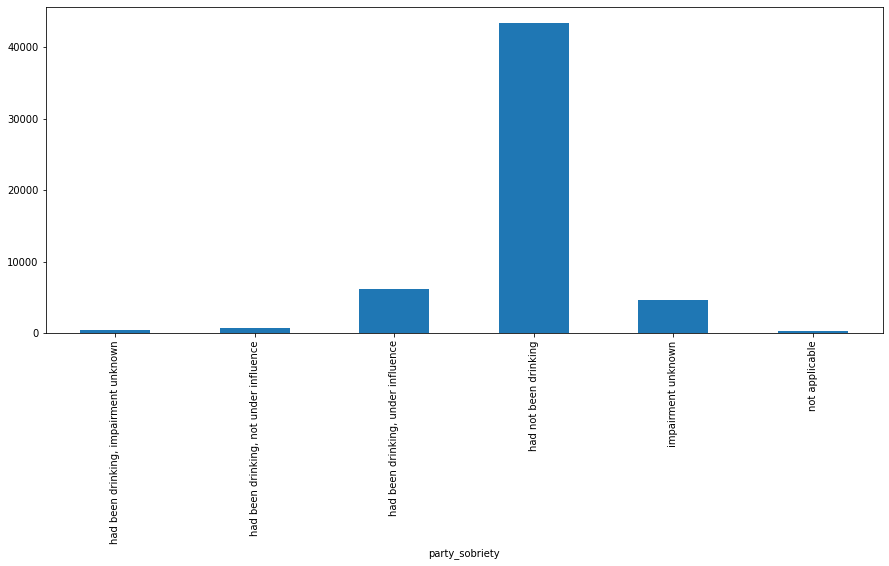

In [128]:
group_party_sobriety = df[df['at_fault'] == 1].groupby('party_sobriety')['at_fault'].count().plot(kind='bar', figsize=(15, 6))

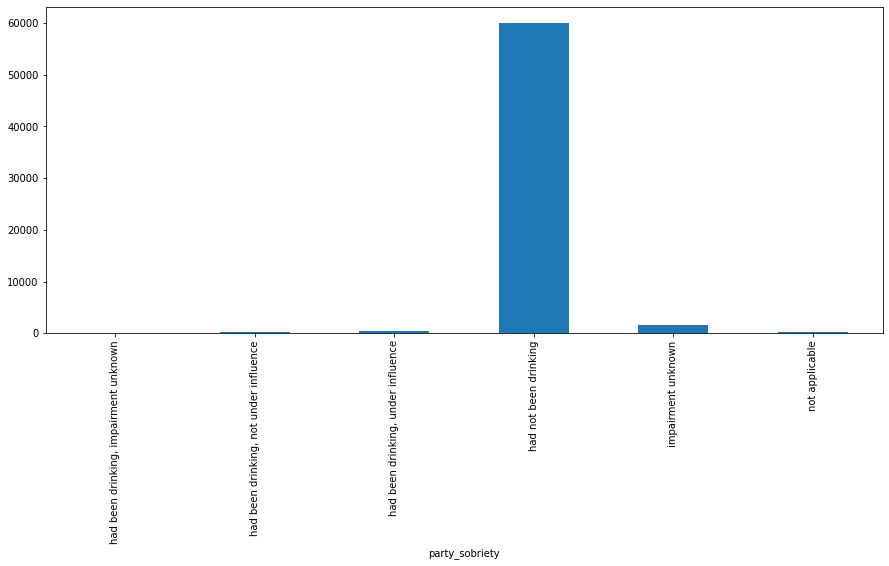

In [129]:
y_sobriety = df[df['at_fault'] == 0].groupby('party_sobriety')['at_fault'].count().plot(kind='bar', figsize=(15, 6))

Выявили, что самый важный фактор ДТП — уровень трезвости виновника party_sobriety. Из таблицы исходных данных известно, что есть несколько уровней трезвости. Благодоря столбчатой диаграмм, которая отражает зависимость  числа ДТП от уровня трезвости, можно сделать вывод, что в основном ДТП происходят, когда участник трезв, но вероятность виновности в ДТП выше, когда участник пьян.
Для решения проблемы необходимо оборудовать автомобиль анализатором алкогольного опьянения. Измерение состояния при посадке сделать обязательным условием допуска за руль. А чтобы убедиться, что в трубку дышит именно водитель, добавить камеру, направленную на водительское место.

Наилучшей оказалась модель CatBoost (с гиперпараметрами depth - 6, iterations - 100, learning_rate - 0.002), которая на тестовой выборке показала результаты ROC-AUC 0.709, количество FN ответов 8684, FP - 477. Для улучшения модели можно добавить такие признаки, как стаж вождения, количество штрафов за нарушение ПДД, попадал ли ранее в ДТП.